# Skyline Hospital Time Series Forecasting with XGBoost 

## Business Problem Overview

The healthcare facility is looking to forecast **patient arrivals** to better manage resources, optimize staffing, and prepare for fluctuations in demand. By predicting the number of patient visits in advance, the facility can ensure efficient use of resources, avoid over or under-staffing, and improve patient care delivery.

Historical patient data, which may include day of the week, seasonal patterns, and past arrivals, is used to create a time-series model. This model helps predict future patient volumes, allowing the facility to anticipate needs.

## Solution Overview

The provided solution ipynb employs the following steps:

1. **Data Preprocessing**: The historical patient data is processed to extract relevant features such as date, lagged patient counts (7-day, 14-day lags, etc.), and other potential influencing factors.
   
2. **Feature Engineering**: Lag features are added to the dataset to help the model capture temporal patterns and trends over time.

3. **Modeling**: A machine learning model, likely an XGBoost regressor, is trained to forecast future patient arrivals. This model uses the processed data and engineered features to make predictions.

4. **Forecasting**: The trained model is used to predict future patient visits, and the results are visualized using a Plotly chart. This forecast provides an estimate of future patient demand over a specified period.

5. **Model Saving**: The trained model is saved for future use, allowing the facility to generate updated forecasts without retraining the model each time.

## Conclusion

By leveraging historical data and machine learning, the healthcare facility can make data-driven decisions regarding patient arrival forecasting, ensuring optimal staffing and resource allocation. The forecasting model provides actionable insights that improve the efficiency and effectiveness of healthcare service delivery.


## 1. Import required libraries and modules

In [1]:
# Data manipulation libraries
import pandas as pd
import pyarrow
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Plot aesthetics
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))

import warnings
warnings.filterwarnings('ignore')

# ML algorithm for time series forecasting
import xgboost as xgb

# Error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error  

<Figure size 1200x600 with 0 Axes>

## 2. Load and read the data

In [4]:
filepath = 'skyline_hospital_bill_charge_report.csv'
df = pd.read_csv(filepath)

# Print the first 5 rows of the data
df.head()

,Open Date,Bill No.,Charge Head,Doctor Code,Qty
0,2020-05-18,BL427653,OP Consultation,DOC0114,1
1,2020-05-18,BL427654,OP Consultation,DOC0114,1
2,2020-05-18,BL427655,OP Consultation,DOC0207,1
3,2020-05-18,BL427656,OP Consultation,DOC0114,1
4,2020-05-18,BL427657,OP Consultation,DOC0114,1


In [5]:
df.tail()

,Open Date,Bill No.,Charge Head,Doctor Code,Qty
126152,2022-12-31,BL678528,OP Consultation,DOC0553,1
126153,2022-12-31,BL678529,OP Consultation,DOC0207,1
126154,2022-12-31,BL678530,OP Consultation,DOC0114,1
126155,2022-12-31,BL678531,OP Consultation,DOC0114,1
126156,2022-12-31,BL678535,OP Consultation,DOC0207,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126157 entries, 0 to 126156
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Open Date    126157 non-null  object
 1   Bill No.     126157 non-null  object
 2   Charge Head  126157 non-null  object
 3   Doctor Code  126157 non-null  object
 4   Qty          126157 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.8+ MB


The dataset is a bill charge report from Skyline Hospital and Medical Center's outpatient unit. It lists down **outpatient consultations from 2020-05-18 to 2022-12-31**, providing us with **2 years, 7 months, and 14 days** worth of outpatient consultations.

It can be seen that the number of observations is large. There are 126,157 observations (rows) and 5 variables (columns). The column names include: `'Bill No.'`, `'Open Date'`, `'Charge Head'`, `'Doctor Code'`, and `'Qty`. For time series forecasting, only the dates (`Open Date`) and the count of outpatient consultations (`Qty`) shall be used. Therefore, the 3 remaining columns are to be dropped, which will make this a time series data.

## 3. Data Cleaning

In [7]:
# Subset the data to only include `'Open Date'` and `'Qty'`
df = df[['Open Date', 'Qty']]
df.columns

Index(['Open Date', 'Qty'], dtype='object')

To make the columns more understandable, we can rename `'Open Date'` as `'Date'` and `'Qty'` as `'Patients'`, representing the number of patients for each date.

In [8]:
df = df.rename(columns={'Open Date': 'Date', 'Qty': 'Patients'})
df.columns

Index(['Date', 'Patients'], dtype='object')

In [9]:
df.dtypes

Date        object
Patients     int64
dtype: object

We can see that the `'Date'` column is read with an `object` data type. We must change this to the pandas `datetime` format using `to_datetime()`. This will allow us to truly perceive it as time data, and use appropriate `datetime` functions for it.

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date        datetime64[ns]
Patients             int64
dtype: object

We can leave the `Patients` column's data type as is, an integer data type. Now let's have another look on our data.

In [11]:
df['Date'].value_counts()

Date
2022-11-26    315
2022-10-01    306
2022-11-05    297
2022-06-11    293
2022-08-06    283
             ... 
2021-05-23      1
2021-05-02      1
2021-04-25      1
2021-04-04      1
2022-07-10      1
Name: count, Length: 856, dtype: int64

In [12]:
df['Date']

0        2020-05-18
1        2020-05-18
2        2020-05-18
3        2020-05-18
4        2020-05-18
            ...    
126152   2022-12-31
126153   2022-12-31
126154   2022-12-31
126155   2022-12-31
126156   2022-12-31
Name: Date, Length: 126157, dtype: datetime64[ns]

Having a closer look at our time series data lets us know that we have duplicated dates, and the **patient arrival counts are not summed up in one date** or instance. This is why we have more observations (rows) than what is expected. An easy fix for this would be to use `groupby()` on the `'Date'` column with the `sum()` method on the `'Patients'` column.

In [13]:
df = df.groupby(by='Date', as_index=False)['Patients'].sum()
df['Date'].value_counts()

Date
2020-05-18    1
2022-02-05    1
2022-02-08    1
2022-02-09    1
2022-02-10    1
             ..
2021-04-07    1
2021-04-08    1
2021-04-09    1
2021-04-10    1
2022-12-31    1
Name: count, Length: 856, dtype: int64

In [14]:
df[df['Date'].duplicated()]

,Date,Patients


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      856 non-null    datetime64[ns]
 1   Patients  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


Since this seems to be cleaned enough data, we can save the time series data that was once a csv file, into a **parquet file**. This would allow us to **reduce memory consumption**.                                  

In [17]:
df.to_parquet('patient_arrivals.parquet')

Let's load and read the data once again.

In [18]:
parquet_file = 'patient_arrivals.parquet'
df = pd.read_parquet(parquet_file, engine='pyarrow')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856 entries, 0 to 855
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      856 non-null    datetime64[ns]
 1   Patients  856 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.5 KB


A convention with time series data is to set the `datetime` column into an index.

In [20]:
df = df.set_index('Date')
df

,Patients
Date,
2020-05-18,67
2020-05-19,75
2020-05-20,74
2020-05-21,55
2020-05-22,62
...,...
2022-12-27,114
2022-12-28,156
2022-12-29,105


In [21]:
new_index = pd.date_range(start='2020-05-18', end='2022-12-31', freq='D')
df = df.reindex(new_index)
df.index.name = 'Date'
df

,Patients
Date,
2020-05-18,67.0
2020-05-19,75.0
2020-05-20,74.0
2020-05-21,55.0
2020-05-22,62.0
...,...
2022-12-27,114.0
2022-12-28,156.0
2022-12-29,105.0


In [23]:
fig = go.Figure()

# Add scatter trace for patients
fig.add_trace(go.Scatter(x=df.index, y=df['Patients'], 
                          mode='lines', 
                          name='Number of Patients'))

# Add markers for missing values
missing_dates = df[df['Patients'].isna()].index
missing_values_trace = go.Scatter(x=missing_dates, y=[df['Patients'].min()]*len(missing_dates),
                                  mode='markers', marker=dict(color='red', symbol='x'),
                                  name='Missing Values')
fig.add_trace(missing_values_trace)

# Set plot title and axis labels
fig.update_layout(title='Daily Patient Arrivals (with Missing Values)',
                  xaxis_title='Date', yaxis_title='Patient Count')

# Show plot
fig.show()

In [24]:
missing_vals = df[df['Patients'].isna()]
missing_vals

,Patients
Date,
2020-05-24,NaN
2020-05-31,NaN
2020-06-07,NaN
2020-06-14,NaN
2020-06-21,NaN
...,...
2022-09-18,NaN
2022-09-25,NaN
2022-10-02,NaN


We can see **102 missing instances** of patient arrival counts. To see the pattern of missing values, we can add a time series feature to identify which days of the week are the missing values coming from.

In [25]:
df = df.copy()
df['date'] = df.index
df['day_of_week'] = df['date'].dt.dayofweek
df.head()

,Patients,date,day_of_week
Date,,,
2020-05-18,67.0,2020-05-18,0
2020-05-19,75.0,2020-05-19,1
2020-05-20,74.0,2020-05-20,2
2020-05-21,55.0,2020-05-21,3
2020-05-22,62.0,2020-05-22,4


The week numbers in the `'day_of_week'` here could be perceived as:

- `0` : `Monday`
- `1` : `Tuesday`
- `2` : `Wednesday`
- `3` : `Thursday`
- `4` : `Friday`
- `5` : `Saturday`
- `6` : `Sunday`


<Axes: xlabel='day_of_week'>

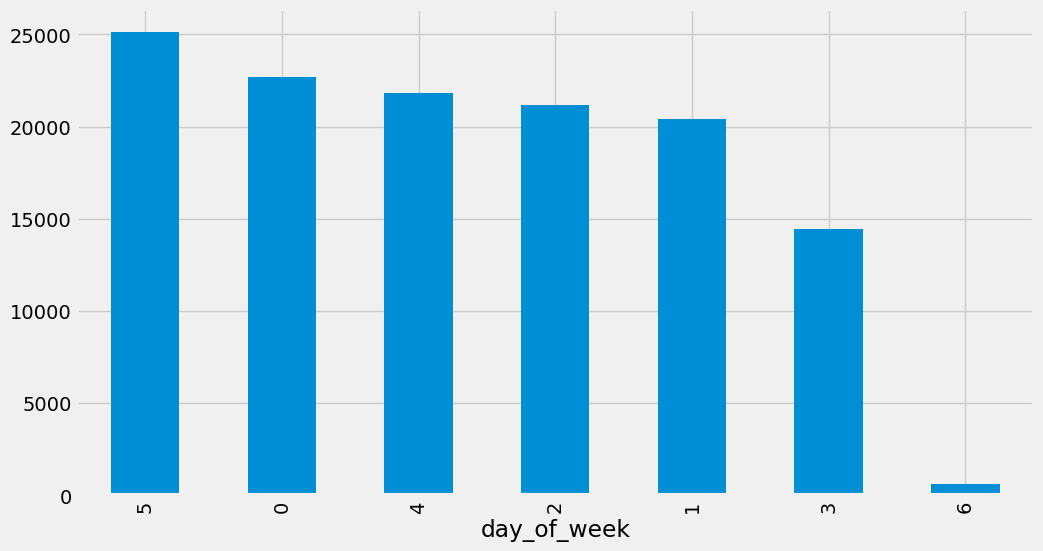

In [26]:
df.groupby('day_of_week')['Patients'].sum().sort_values(ascending=False) \
    .plot(kind='bar', figsize=(11, 6))

**Saturday** seems to be the day of the week with the **highest patient arrival counts**. Consequently, **Sunday** seems to be the one with the **lowest patient arrival counts**. What could this possibly mean?

![https://www.facebook.com/SkylineHospitalAndMedicalCenter/photos/a.944515819031784/1924894020993954/](./pictures/opening_now_on_sundays.jpg)

**Source:** [Facebook](https://www.facebook.com/SkylineHospitalAndMedicalCenter/photos/a.944515819031784/1924894020993954/)

Skyline Hospital and Medical Center has announced that starting on June 13, 2021, the outpatient unit will start to be active. This may explain why there seems to be a **weekly pattern of missing values during Sundays**, and that it seems to be the day of the week with the lowest count of patient arrival counts.

However, this would not explain why **there still seems to be Sundays with missing values**. To make our time series data seem more relevant to new data, we can **pick a point in time when the missing values have stopped**, and continue on from there. In this case, we can choose **October 17, 2022 as our new starting point**.

In [27]:
df = df.loc['2022-10-17'::]
df

,Patients,date,day_of_week
Date,,,
2022-10-17,205.0,2022-10-17,0
2022-10-18,182.0,2022-10-18,1
2022-10-19,210.0,2022-10-19,2
2022-10-20,103.0,2022-10-20,3
2022-10-21,179.0,2022-10-21,4
...,...,...,...
2022-12-27,114.0,2022-12-27,1
2022-12-28,156.0,2022-12-28,2
2022-12-29,105.0,2022-12-29,3


In [28]:
df.isna().sum()

Patients       0
date           0
day_of_week    0
dtype: int64

Now we have no more missing values, and we have even cleaner data. We can now save this once again as the new dataset that we will work with. I will use the parquet file format once again to reduce memory consumption.

In [31]:
df.to_parquet('october_17_22_to_dec_31_22_patient_arrivals_data.parquet')

We will leave the `'date'` column for now (which is a duplicate of the old and indexed `'Date'` column) as we will need it for **feature engineering** and **model building**.

In [32]:
df['Patients'].describe()

count     76.000000
mean     160.157895
std       81.332741
min        6.000000
25%      110.750000
50%      187.000000
75%      214.000000
max      315.000000
Name: Patients, dtype: float64

### Time series decomposition

We can try to decompose the time series data to know its **trend, seasonality, and residual** components.

In [33]:
from statsmodels.tsa.seasonal import STL

In [34]:
patients_series = df['Patients']

# Perform STL decomposition
stl = STL(patients_series, seasonal=7)
result = stl.fit()
print(stl, result, sep='\n')

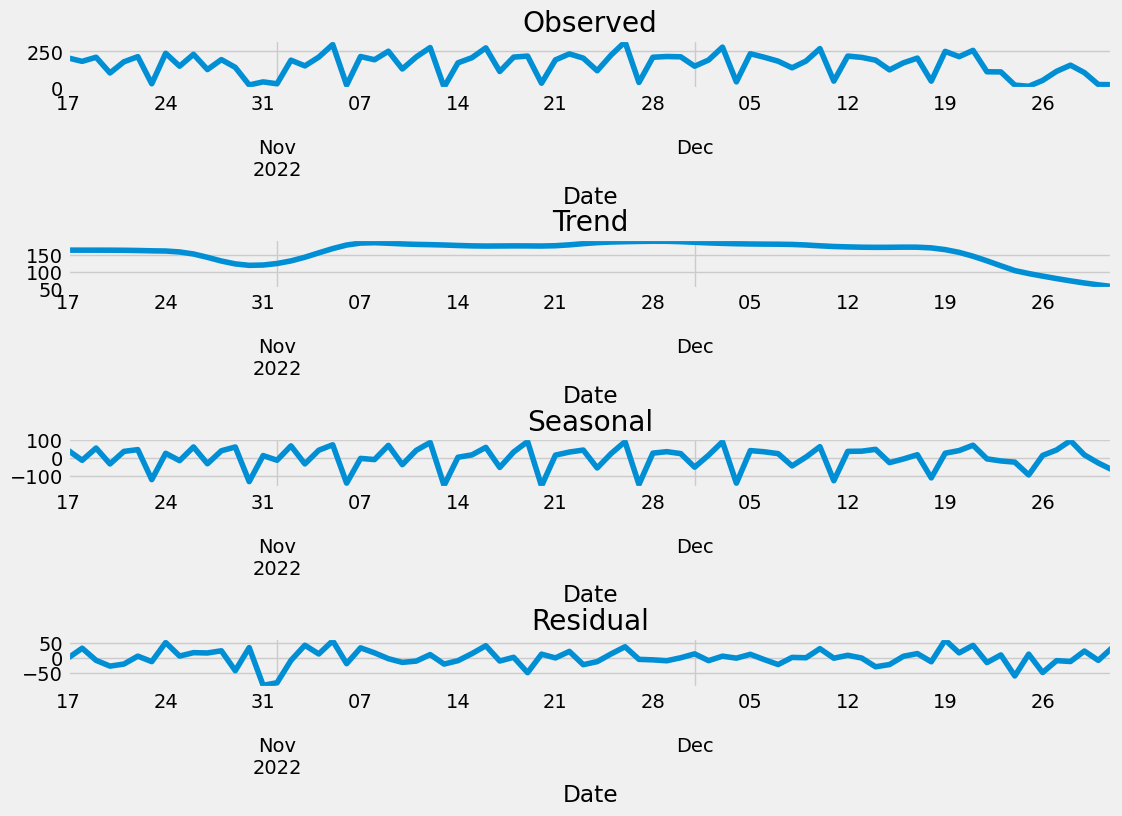

In [35]:
# Plot the components
fig, ax = plt.subplots(4, 1, figsize=(12, 8))
plt.subplots_adjust(hspace=3)

# Observed component
result.observed.plot(ax=ax[0], legend=False)
ax[0].set_title('Observed')

# Trend component
result.trend.plot(ax=ax[1], legend=False)
ax[1].set_title('Trend')

# Seasonal component
result.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_title('Seasonal')

# Residual component
result.resid.plot(ax=ax[3], legend=False)
ax[3].set_title('Residual')

# Show plot
plt.show()

We can see from the time series decomposition that it has no uptrend, it has some seasonality, and a fairly strong residual component.

### Outlier detection and handling

To detect and handle outliers, we will make use of the interquartile (IQR) method.

In [36]:
# Calculate the 25th and 75th quantiles and the IQR
Q1 = patients_series.quantile(0.25)
Q3 = patients_series.quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds
lower_bound = Q1 - 0.1 * IQR
upper_bound = Q3 + 0.9 * IQR

print(f'Lower Bound: {lower_bound}')
print(f'Upper Bound: {upper_bound}')

Lower Bound: 100.425
Upper Bound: 306.925


In [37]:
def custom_winsorize(x):
    if x < lower_bound:
        return lower_bound
    elif x > upper_bound:
        return upper_bound
    else:
        return x

cleaned_series = patients_series.copy()
cleaned_series = cleaned_series.apply(custom_winsorize)
df['Patients'] = cleaned_series.copy()

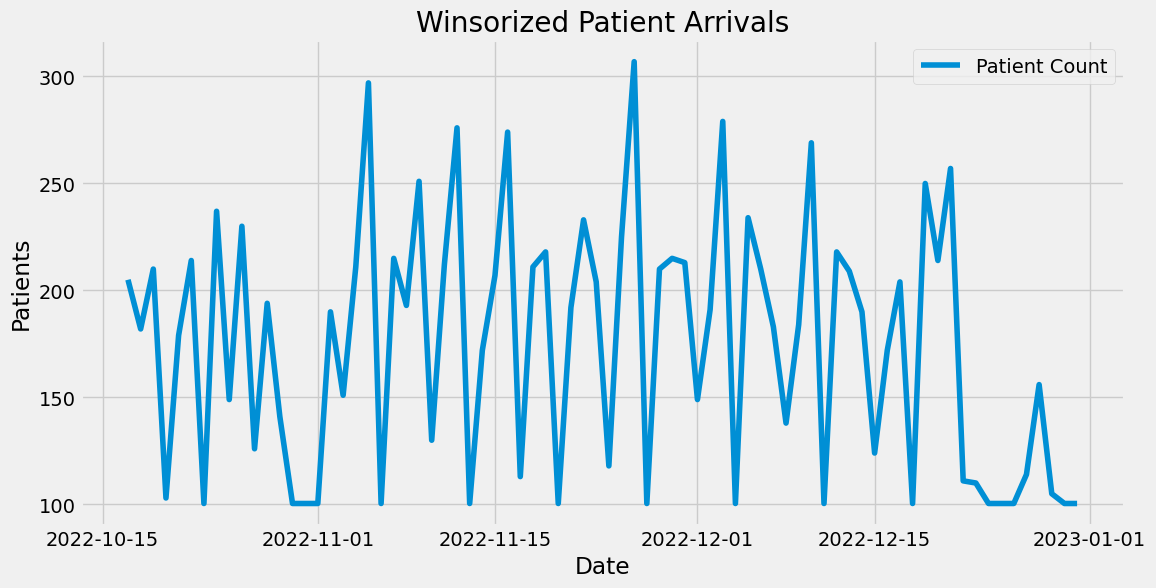

In [38]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the winsorized time series data
ax.plot(df.index, 'Patients', data=df,
       label='Patient Count')

# Plot title and labels
ax.set_title('Winsorized Patient Arrivals')
ax.set_xlabel('Date')
ax.set_ylabel('Patients')

# Show legend
plt.legend()

# Show plot
plt.show()

## 4. Feature engineering

We now proceed to do feature engineering to enrich the data and try to improve model performance. We actually have already added the day of week as `'day_of_week'` column, now we will add other time series features.

In [39]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    
    window_size = 7  # 7-day rolling window
    
    # Rolling minimum
    df['rolling_min'] = df['Patients'].rolling(window=window_size).min()
    
    # Rolling maximum
    df['rolling_max'] = df['Patients'].rolling(window=window_size).max()
    
    # Rolling sum
    df['rolling_sum'] = df['Patients'].rolling(window=window_size).sum()
    
    # Rollling mean
    df['rolling_mean'] = df['Patients'].rolling(window=window_size).mean()
    
    # Rolling median
    df['rolling_median'] = df['Patients'].rolling(window=window_size).median()
    
    # Rolling standard deviation
    df['rolling_std'] = df['Patients'].rolling(window=window_size).std()
    
    # Rolling 25th percentile
    df['rolling_quantile_25'] = df['Patients'].rolling(window=window_size).quantile(0.25)
    
    # Rolling 75th percentile
    df['rolling_quantile_75'] = df['Patients'].rolling(window=window_size).quantile(0.75)

    return df

df = create_features(df)
df.dtypes

Patients                      float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
dtype: object

## 5. Model Building

Now that we have finished feature engineering, it is time to build our forecasting model. Before we actually try to build it, we first do **time series cross-validation**.

### Time series cross-validation

In [40]:
from sklearn.model_selection import TimeSeriesSplit

In [41]:
tss = TimeSeriesSplit(n_splits=5, test_size=10, gap=1)
df = df.sort_index()

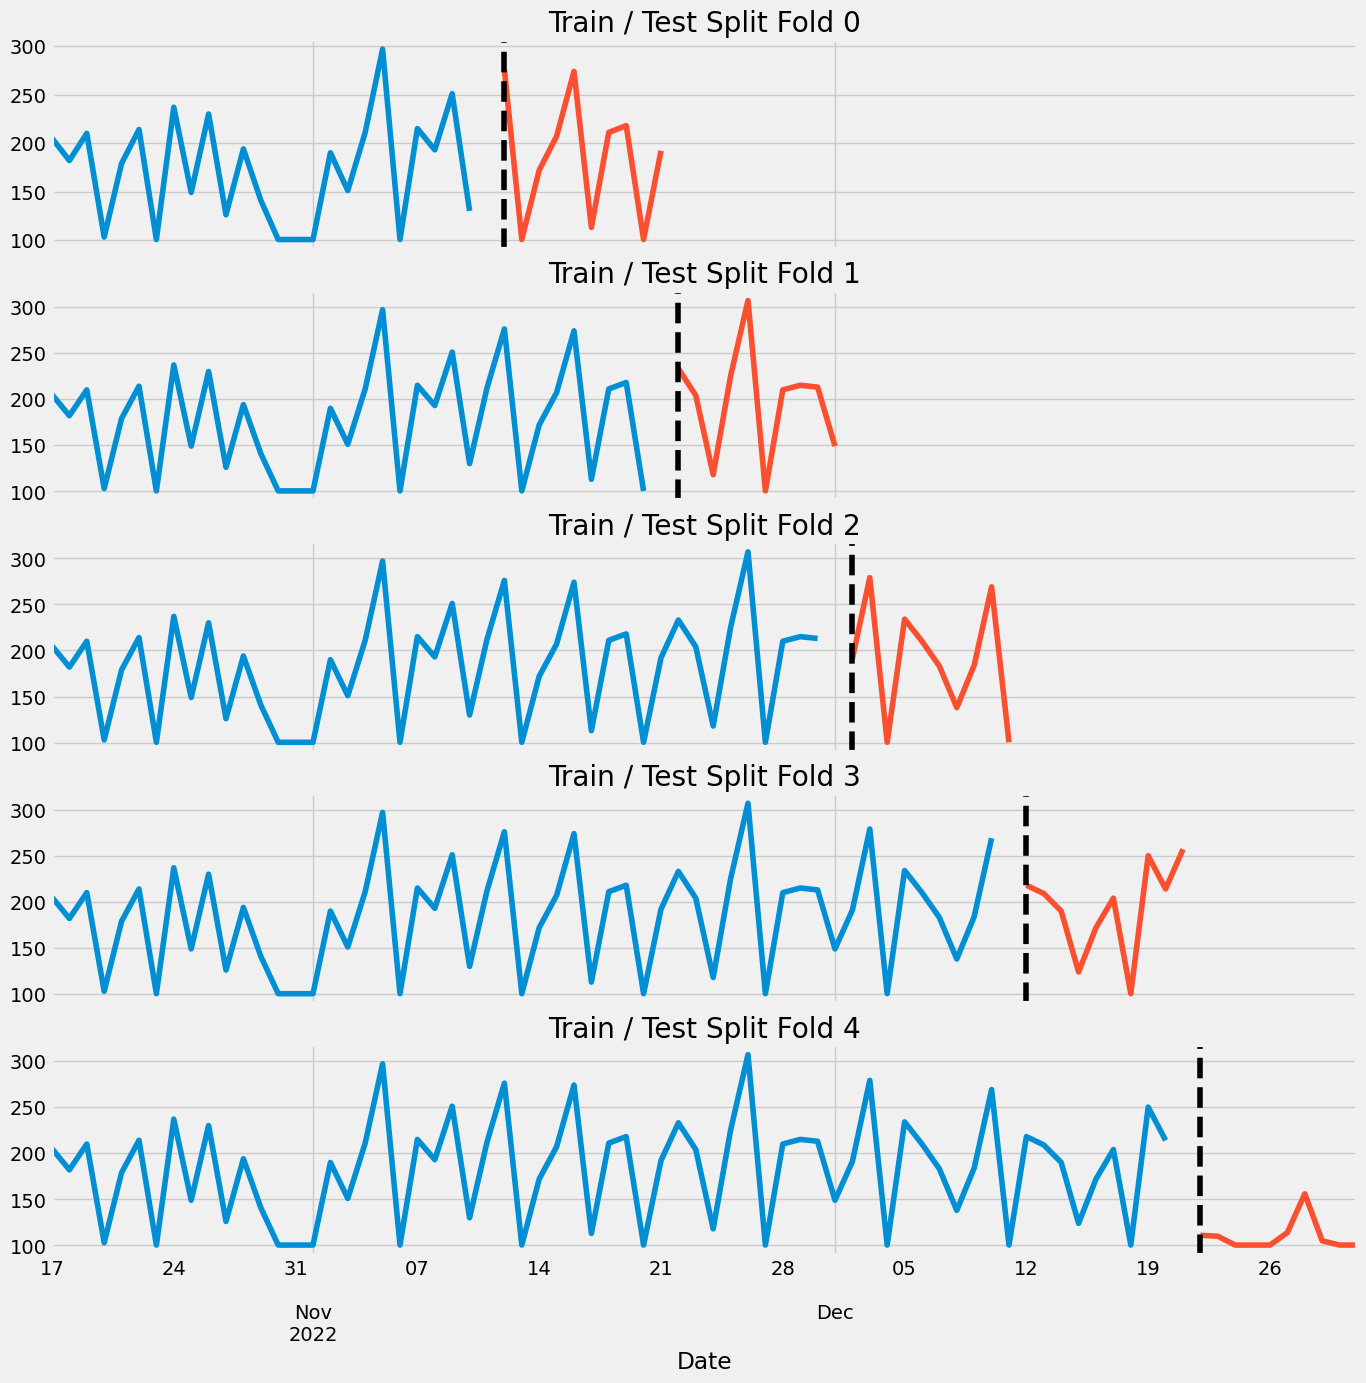

In [42]:
# Create figure and axes
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# Initalize the fold
fold = 0

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]
    
    train['Patients'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Train / Test Split Fold {fold}')

    test['Patients'].plot(ax=axs[fold], label='Test Set')

    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

### Forecasting Horizon

In [43]:
df

,Patients,date,day_of_week,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,rolling_median,rolling_std,rolling_quantile_25,rolling_quantile_75
Date,,,,,,,,,,,,,
2022-10-17,205.000,2022-10-17,0,10,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-18,182.000,2022-10-18,1,10,291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-19,210.000,2022-10-19,2,10,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-20,103.000,2022-10-20,3,10,293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-21,179.000,2022-10-21,4,10,294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,114.000,2022-12-27,1,12,361,100.425,257.0,893.275,127.610714,110.000,57.344109,100.425,112.5
2022-12-28,156.000,2022-12-28,2,12,362,100.425,156.0,792.275,113.182143,110.000,19.736428,100.425,112.5
2022-12-29,105.000,2022-12-29,3,12,363,100.425,156.0,786.275,112.325000,105.000,19.975829,100.425,112.0


Now we add time lags, which will also determine how far in the future do we want to forecast. For this data, we can try to forecast for up to **2 months.** These would also be added features for our data.

In [44]:
def add_lags(df):
    """
    Create time lags for added time series features and allow the model to learn the temporal structure of the data.
    """
    target_map = df['Patients'].to_dict()
    df['lag_7_days'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_14_days'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag_21_days'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    df['lag_28_days'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_30_days'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag_35_days'] = (df.index - pd.Timedelta('35 days')).map(target_map)
    df['lag_42_days'] = (df.index - pd.Timedelta('42 days')).map(target_map)
    df['lag_49_days'] = (df.index - pd.Timedelta('49 days')).map(target_map)
    df['lag_56_days'] = (df.index - pd.Timedelta('56 days')).map(target_map)
    df['lag_60_days'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    
    return df

df = add_lags(df)
df

,Patients,date,day_of_week,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,rolling_median,...,lag_7_days,lag_14_days,lag_21_days,lag_28_days,lag_30_days,lag_35_days,lag_42_days,lag_49_days,lag_56_days,lag_60_days
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-17,205.000,2022-10-17,0,10,290,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-18,182.000,2022-10-18,1,10,291,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-19,210.000,2022-10-19,2,10,292,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-20,103.000,2022-10-20,3,10,293,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-21,179.000,2022-10-21,4,10,294,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,114.000,2022-12-27,1,12,361,100.425,257.0,893.275,127.610714,110.000,...,214.000,209.0,210.0,215.0,100.425,233.000,207.0,193.0,100.425,194.000
2022-12-28,156.000,2022-12-28,2,12,362,100.425,156.0,792.275,113.182143,110.000,...,257.000,190.0,183.0,213.0,210.000,204.000,274.0,251.0,190.000,141.000
2022-12-29,105.000,2022-12-29,3,12,363,100.425,156.0,786.275,112.325000,105.000,...,111.000,124.0,138.0,149.0,215.000,118.000,113.0,130.0,151.000,100.425


## 6. Model Training

Now we start the **model training phase**. We begin this phase by first defining the error metrics to be used for measuring the model's performance.

In [45]:
# Define error metrics

# Root mean squared error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Mean absolute percentage error (MAPE)
def mean_absolute_percentage_error(y_true,  y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Symmetric mean absolute percentage error (sMAPE)
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

In [46]:
df.columns

Index(['Patients', 'date', 'day_of_week', 'month', 'day_of_year',
       'rolling_min', 'rolling_max', 'rolling_sum', 'rolling_mean',
       'rolling_median', 'rolling_std', 'rolling_quantile_25',
       'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days',
       'lag_28_days', 'lag_30_days', 'lag_35_days', 'lag_42_days',
       'lag_49_days', 'lag_56_days', 'lag_60_days'],
      dtype='object')

In [47]:
df.dtypes

Patients                      float64
date                   datetime64[ns]
day_of_week                     int32
month                           int32
day_of_year                     int32
rolling_min                   float64
rolling_max                   float64
rolling_sum                   float64
rolling_mean                  float64
rolling_median                float64
rolling_std                   float64
rolling_quantile_25           float64
rolling_quantile_75           float64
lag_7_days                    float64
lag_14_days                   float64
lag_21_days                   float64
lag_28_days                   float64
lag_30_days                   float64
lag_35_days                   float64
lag_42_days                   float64
lag_49_days                   float64
lag_56_days                   float64
lag_60_days                   float64
dtype: object

In [48]:
tss = TimeSeriesSplit(n_splits=5, test_size=5, gap=1)
df = df.sort_index()

# Initialize the start of the fold
fold = 0

# Create empty list for the predictions
preds = []

# Make empty lists for the error metric scores
rmse_scores = []
mape_scores = []
smape_scores = []

# Initialize an empty DataFrame to store actual and predicted values
actual_vs_pred_df = pd.DataFrame()

for train_index, val_index in tss.split(df):
    train = df.iloc[train_index]
    test = df.iloc[val_index]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
                'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
                'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
                'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days']

    TARGET = 'Patients'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=400,
                           early_stopping_rounds=50,
                           tree_method='hist',
                           objective='reg:squarederror',
                           max_depth=3,
                           min_child_weight=3,
                           gamma=0,
                           learning_rate=0.01,
                           colsample_bytree=0.5,
                           subsample=0.7,
                           reg_lambda=0)

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)

    rmse = root_mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)

    rmse_scores.append(rmse)
    mape_scores.append(mape)
    smape_scores.append(smape)

    # Store actual and predicted values along with their datetime index in the DataFrame
    temp_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=df.iloc[val_index].index)
    actual_vs_pred_df = pd.concat([actual_vs_pred_df, temp_df])

[0]	validation_0-rmse:190.01423	validation_1-rmse:181.20912
[100]	validation_0-rmse:75.01354	validation_1-rmse:61.87067
[200]	validation_0-rmse:34.85472	validation_1-rmse:24.68082
[300]	validation_0-rmse:21.62404	validation_1-rmse:23.06221
[304]	validation_0-rmse:21.32478	validation_1-rmse:23.08419
[0]	validation_0-rmse:190.86099	validation_1-rmse:182.98928
[100]	validation_0-rmse:75.19553	validation_1-rmse:57.62739
[200]	validation_0-rmse:34.51656	validation_1-rmse:18.11505
[290]	validation_0-rmse:22.02311	validation_1-rmse:16.00395
[0]	validation_0-rmse:189.40828	validation_1-rmse:210.00374
[100]	validation_0-rmse:74.28481	validation_1-rmse:86.89068
[200]	validation_0-rmse:33.96228	validation_1-rmse:46.85538
[300]	validation_0-rmse:20.76960	validation_1-rmse:40.07633
[399]	validation_0-rmse:16.18795	validation_1-rmse:39.43193
[0]	validation_0-rmse:189.60752	validation_1-rmse:102.27551
[100]	validation_0-rmse:74.20766	validation_1-rmse:33.35555
[121]	validation_0-rmse:61.87945	validat

In [49]:
temp_df

,Actual,Predicted
Date,,
2022-12-27,114.000,128.065460
2022-12-28,156.000,132.859070
2022-12-29,105.000,92.570953
2022-12-30,100.425,103.083107
2022-12-31,100.425,124.029831


## 7. Model Evaluation

In [50]:
# Print the error metric results
print(f'RMSE across folds: {np.mean(rmse_scores):.3f}')
print(f'MAPE across folds: {np.mean(mape_scores):.3f}%')
print(f'sMAPE across folds: {np.mean(smape_scores):.3f}%')

RMSE across folds: 23.877
MAPE across folds: 13.647%
sMAPE across folds: 13.917%


In [51]:
# Display the DataFrame
actual_vs_pred_df

,Actual,Predicted
Date,,
2022-12-07,183.000,206.338608
2022-12-08,138.000,141.775391
2022-12-09,184.000,201.287689
2022-12-10,269.000,230.674438
2022-12-11,100.425,108.410004
2022-12-12,218.000,194.740845
2022-12-13,209.000,203.285294
2022-12-14,190.000,190.753403
2022-12-15,124.000,144.030777


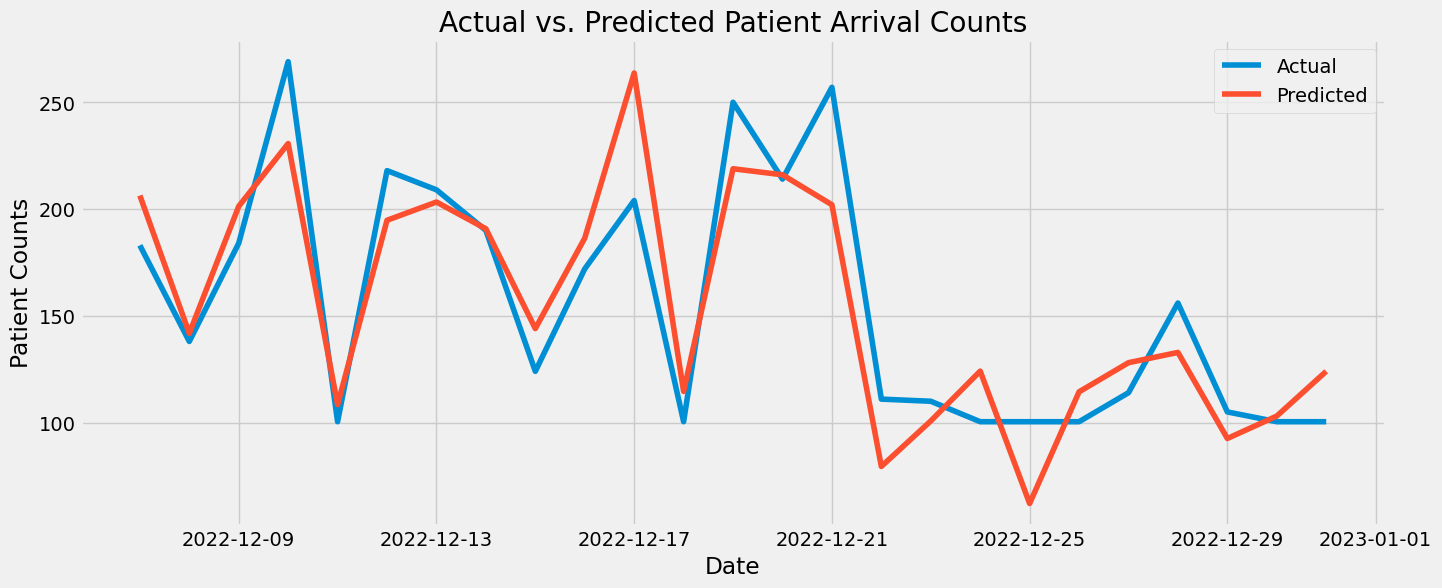

In [52]:
# Create figure
plt.figure(figsize=(15, 6))

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual')
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted')

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Patient Counts')
plt.title('Actual vs. Predicted Patient Arrival Counts')

# Show legend
plt.legend()

# Show plot
plt.show()

## 8. Forecast the future

In [53]:
# Retrain on all the data
df = create_features(df)

FEATURES = ['day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
            'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
            'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days']

TARGET = 'Patients'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=400,
                       early_stopping_rounds=50,
                       tree_method='hist',
                       objective='reg:squarederror',
                       max_depth=3,
                       min_child_weight=3,
                       gamma=0,
                       learning_rate=0.01,
                       colsample_bytree=0.5,
                       subsample=0.7,
                       reg_lambda=0)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)],
       verbose=100)


[0]	validation_0-rmse:182.18298
[100]	validation_0-rmse:72.26257
[200]	validation_0-rmse:34.05423
[300]	validation_0-rmse:21.78150
[399]	validation_0-rmse:17.29202


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [54]:
df.index.max()

Timestamp('2022-12-31 00:00:00')

In [55]:
# Create future DataFrame
future = pd.date_range(start='2022-12-31', end='2023-03-01', freq='D')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True
df['isFuture'] = False

df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

df_and_future

,Patients,date,day_of_week,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,rolling_median,...,lag_14_days,lag_21_days,lag_28_days,lag_30_days,lag_35_days,lag_42_days,lag_49_days,lag_56_days,lag_60_days,isFuture
2022-10-17,205.0,2022-10-17,0.0,10.0,290.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-10-18,182.0,2022-10-18,1.0,10.0,291.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-10-19,210.0,2022-10-19,2.0,10.0,292.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-10-20,103.0,2022-10-20,3.0,10.0,293.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2022-10-21,179.0,2022-10-21,4.0,10.0,294.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-25,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.000,True
2023-02-26,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.000,True
2023-02-27,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.000,True
2023-02-28,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.425,True


In [56]:
future_with_features = df_and_future.query('isFuture').copy()
future_with_features

,Patients,date,day_of_week,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,rolling_median,...,lag_14_days,lag_21_days,lag_28_days,lag_30_days,lag_35_days,lag_42_days,lag_49_days,lag_56_days,lag_60_days,isFuture
2022-12-31,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,204.000,269.000,279.000,149.000,306.925,218.000,276.000,297.000,100.425,True
2023-01-01,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.425,100.425,100.425,191.000,100.425,100.425,100.425,100.425,190.000,True
2023-01-02,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,250.000,218.000,234.000,279.000,210.000,192.000,172.000,215.000,151.000,True
2023-01-03,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,214.000,209.000,210.000,100.425,215.000,233.000,207.000,193.000,211.000,True
2023-01-04,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,257.000,190.000,183.000,234.000,213.000,204.000,274.000,251.000,297.000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-25,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.000,True
2023-02-26,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.000,True
2023-02-27,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.000,True
2023-02-28,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.425,True


### Feature Importance

In [57]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
feature_importance

,importance
day_of_week,0.067588
month,0.026414
day_of_year,0.046136
rolling_min,0.002038
rolling_max,0.032931
rolling_sum,0.066510
rolling_mean,0.071594
rolling_median,0.078067
rolling_std,0.035386
rolling_quantile_25,0.046744


<Axes: title={'center': 'Feature Importance'}>

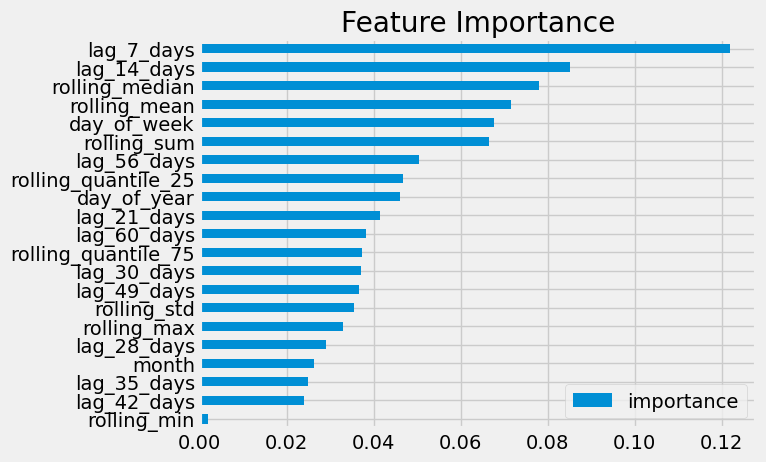

In [58]:
feature_importance \
    .sort_values('importance') \
    .plot(kind='barh', title='Feature Importance')

In [59]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])
future_with_features

,Patients,date,day_of_week,month,day_of_year,rolling_min,rolling_max,rolling_sum,rolling_mean,rolling_median,...,lag_21_days,lag_28_days,lag_30_days,lag_35_days,lag_42_days,lag_49_days,lag_56_days,lag_60_days,isFuture,pred
2022-12-31,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,269.000,279.000,149.000,306.925,218.000,276.000,297.000,100.425,True,137.942215
2023-01-01,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,100.425,100.425,191.000,100.425,100.425,100.425,100.425,190.000,True,110.383163
2023-01-02,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,218.000,234.000,279.000,210.000,192.000,172.000,215.000,151.000,True,162.313232
2023-01-03,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,209.000,210.000,100.425,215.000,233.000,207.000,193.000,211.000,True,160.897781
2023-01-04,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,190.000,183.000,234.000,213.000,204.000,274.000,251.000,297.000,True,175.719879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-25,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.000,True,155.129028
2023-02-26,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.000,True,155.129028
2023-02-27,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.000,True,155.129028
2023-02-28,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.425,True,155.129028


In [60]:
# Create a new figure
fig = go.Figure()

fig.add_trace(go.Scatter(x=future_with_features.index, y=future_with_features['pred'],
                         name='Predicted Patient Arrivals',
                         line=dict(color='blue', width=2),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Patients</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))

fig.update_layout(
    title='Future Forecasts of Patient Arrivals',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Predicted Patient Arrivals',
    template='plotly_white'
)

fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

fig.show()

## 9. Save the model

In [62]:
# Save the model
reg.save_model('xgboost_model_1.json')